# K-measn model

## Ví dụ 1.  
(Data: Khởi tạo 3 tập ngẫu nhiên, mỗi tập N điểm theo phân phối chuẩn Gaussian có 3 kỳ vọng - tâm cụm, và ma trận hiệp phương sai cov)

### Khởi tạo data

In [1]:
#  Gọi các thư viện cần thiết 
# Ta tự xây dựng phần k-means nên sẽ không gọi sklearn 
 
from __future__ import print_function  
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import cdist 
np.random.seed(11) 
 
# Kỳ vọng và hiệp phương sai của 3 cụm dữ liệu 
means = [[2, 2], [8, 3], [3, 6]] 
cov = [[1, 0], [0, 1]] 
 
# Số điểm mỗi cụm dữ liệu 
N = 500 
 
# Tạo các cụm dữ liệu qua phân bố chuẩn (Gaussian) 
X0 = np.random.multivariate_normal(means[0], cov, N) 
X1 = np.random.multivariate_normal(means[1], cov, N) 
X2 = np.random.multivariate_normal(means[2], cov, N) 
# Tổng hợp dữ liệu từ các cụm 
X = np.concatenate((X0, X1, X2), axis = 0) 
 
# Số cụm = 3 
K = 3 
 
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh 
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

### Xây dựng thuật toán bằng Numpy

Xây dựng các hàm thực hiện thuật toán

In [3]:
def kmeans_display(X, label): 
    K = np.amax(label) + 1 
    X0 = X[label == 0, :] 
    X1 = X[label == 1, :] 
    X2 = X[label == 2, :] 
     
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8) 
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8) 
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8) 
 
    plt.axis('equal') 
    plt.plot() 
    plt.show()

In [2]:
def kmeans_init_centers(X, k): 
    # randomly pick k rows of X as initial centers 
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [4]:
def kmeans_assign_labels(X, centers): 
    # calculate pairwise distances btw data and centers 
    D = cdist(X, centers) 
    # return index of the closest center 
    return np.argmin(D, axis = 1)

In [5]:
def kmeans_update_centers(X, labels, K): 
    centers = np.zeros((K, X.shape[1])) 
    for k in range(K): 
        # collect all points assigned to the k-th cluster  
        Xk = X[labels == k, :] 
        # take average 
        centers[k,:] = np.mean(Xk, axis = 0) 
    return centers

In [6]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [7]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0 
    while (it < 100000):
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Sử dụng hàm đã xây dựng

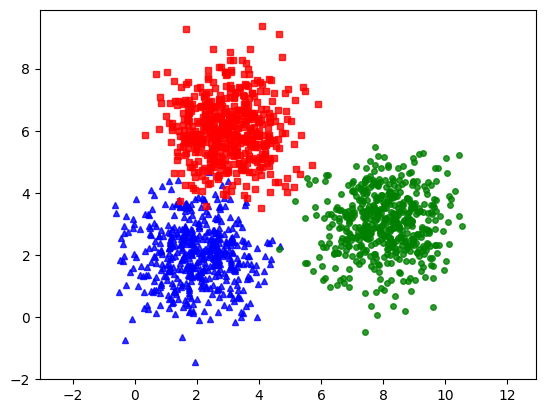

In [8]:
kmeans_display(X, original_label)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


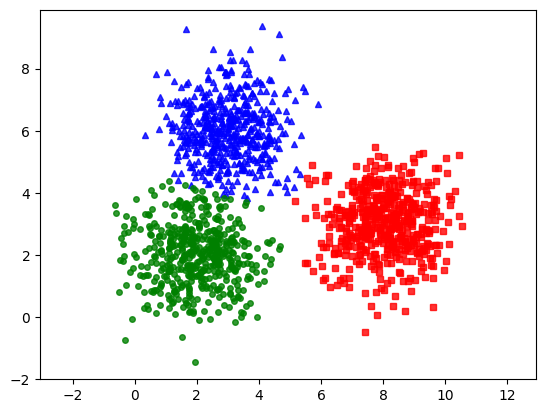

In [9]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])

kmeans_display(X, labels[-1])

### Dùng thư viện sklearn 

Centers found by scikit-learn:
[[8.0410628  3.02094748]
 [2.99357611 6.03605255]
 [1.97634981 2.01123694]]


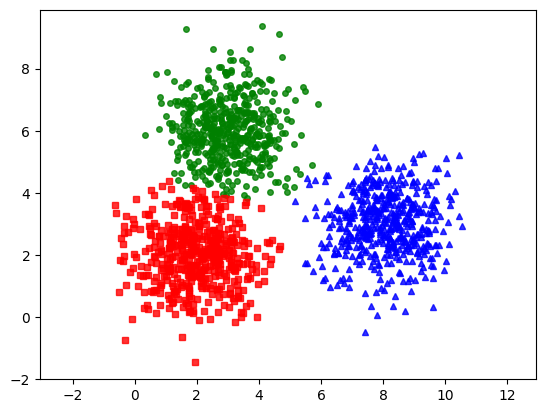

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

## Ví dụ 2.  
(Thực hiện phân cụm cho bộ dữ liệu chữ số viết tay)  
- Đọc 500 mẫu từ phần training  
- Thực hiện phân cụm k-means  
- Kiểm tra trong mỗi cụm, tỷ lệ có nhãn nào là cao nhất  
- Đếm và in ra tỷ lệ mẫu không thuộc nhãn đó nhưng được phân vào cùng 1 nhãn  

Nội dung code mẫu sẽ sử dụng thư viện, tý sẽ dùng hàm numpy tự xây dựng để thực hành ở bài 2

### Xây dựng hàm trực quan hóa dữ liệu

In [4]:
# !pip install python-mnist

In [5]:
import numpy as np  
from mnist import MNIST # do không có mạng 
import matplotlib 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import normalize

In [3]:
# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.
# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.
# source: https://github.com/tsaith/ufldl_tutorial


def display_network(A, m=-1, n=-1):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0

    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[
                    buf + i * (sz + buf) : buf + i * (sz + buf) + sz,
                    buf + j * (sz + buf) : buf + j * (sz + buf) + sz,
                ] = (
                    A[:, k].reshape(sz, sz) / clim
                )
            else:
                image[
                    buf + i * (sz + buf) : buf + i * (sz + buf) + sz,
                    buf + j * (sz + buf) : buf + j * (sz + buf) + sz,
                ] = A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1

    return image


def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """
    if np.min(A) >= 0:
        A = A - np.mean(A)

    cols = np.round(np.sqrt(A.shape[1]))

    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)

    B = A[0:channel_size, :]
    C = A[channel_size : 2 * channel_size, :]
    D = A[2 * channel_size : 3 * channel_size, :]

    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))

    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))

    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp : i * dimp + dim, j * dimp : j * dimp + dim, 0] = B[
                :, i * cols + j
            ].reshape(dim, dim)
            image[i * dimp : i * dimp + dim, j * dimp : j * dimp + dim, 1] = C[
                :, i * cols + j
            ].reshape(dim, dim)
            image[i * dimp : i * dimp + dim, j * dimp : j * dimp + dim, 2] = D[
                :, i * cols + j
            ].reshape(dim, dim)

    image = (image + 1) / 2

    return image

### Chạy cho 1000 mẫu đầu tiên

In [7]:
mndata = MNIST('/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Ass/Week4/data/number_writing/') 
mndata.gz = True
mndata.load_testing() 
X = mndata.test_images 
X0 = np.asarray(X)[:1000,:]/256.0 
X = X0 
 
K = 10 
kmeans = KMeans(n_clusters=K).fit(X) 
 
pred_label = kmeans.predict(X)

<class 'numpy.ndarray'>
(784, 10)


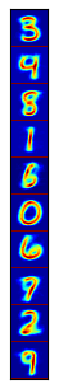

In [11]:
print(type(kmeans.cluster_centers_.T)) 
print(kmeans.cluster_centers_.T.shape) 
A = display_network(kmeans.cluster_centers_.T, K, 1) 
 
f1 = plt.imshow(A, interpolation='nearest', cmap = "jet") 
f1.axes.get_xaxis().set_visible(False) 
f1.axes.get_yaxis().set_visible(False) 
plt.show() 
# plt.savefig('a1.png', bbox_inches='tight') 
 
 
# a colormap and a normalization instance 
cmap = plt.cm.jet 
norm = plt.Normalize(vmin=A.min(), vmax=A.max()) 
 
# map the normalized data to colors 
# image is now RGBA (512x512x4)  
image = cmap(norm(A)) 
# import imageio
# imageio.imwrite('number_writing.jpg', image)

In [14]:
N0 = 20
X1 = np.zeros((N0 * K, 784))
X2 = np.zeros((N0 * K, 784))

for k in range(K):
    Xk = X0[pred_label == k, :]

    center_k = [kmeans.cluster_centers_[k]]
    # neigh = NearestNeighbors(N0).fit(Xk)
    # dist, nearest_id = neigh.kneighbors(center_k, N0)

    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, return_distance=True)

    X1[N0 * k : N0 * k + N0, :] = Xk[nearest_id[0], :]
    # X1[N0 * k : N0 * k + N0, :] = Xk[nearest_id, :]
    X2[N0 * k : N0 * k + N0, :] = Xk[:N0, :]

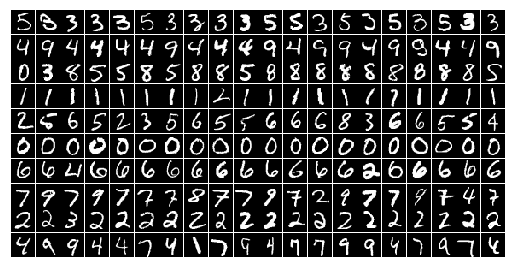

In [15]:
plt.axis('off') 
A = display_network(X2.T, K, N0) 
f2 = plt.imshow(A, interpolation='nearest' ) 
plt.gray() 
plt.show()

## Bài tập tự thực hành

### Bài 1  
Hãy áp dụng đoạn chương trình chúng ta tự xây dựng trong ví dụ 1, với dữ liệu là hình ảnh chữ số viết tay như trong ví dụ 2, chạy để xem xét kết quả.  
(Làm lại ví dụ 2 nhưng bằng hàm tự xây dựng với Numpy)  

In [ ]:
mndata = MNIST('/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Ass/Week4/data/number_writing/') 
mndata.gz = True
mndata.load_testing() 
X = mndata.test_images 
X0 = np.asarray(X)[:1000,:]/256.0 
X = X0 
 
K = 10 
(centers, labels, it) = kmeans(X, K)

(centers, labels, it) = kmeans(X, K) 
print('Centers found by our algorithm:') 
print(centers[-1]) 
 
kmeans_display(X, labels[-1])

### Bài 2  
Áp dụng mô hình trên cho bài tập phân loại ảnh chó-mèo (xem lại phần CNN), thử thực hiện phân cụm thành 02 cụm và kiểm tra kết quả. 

#### Load ảnh chó mèo

In [21]:
import os

base_dir = "/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Ass/Week8/data/cat_dog_panda"
# Change the base_dir to where you put dataset
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f"{base_dir}/train"))

print("\nContents of validation directory:")
print(os.listdir(f"{base_dir}/validation"))

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

print("\nContents of train directory:")
print(os.listdir(f"{base_dir}/train"))

print("\nContents of validation directory:")
print(os.listdir(f"{base_dir}/validation"))

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

print("total training cat images :", len(os.listdir(train_cats_dir)))
print("total training dog images :", len(os.listdir(train_dogs_dir)))

print("total validation cat images :", len(os.listdir(validation_cats_dir)))
print("total validation dog images :", len(os.listdir(validation_dogs_dir)))

Contents of base directory:
['train', 'validation']

Contents of train directory:
['cats', 'dogs', 'panda']

Contents of validation directory:
['cats', 'dogs', 'panda']

Contents of train directory:
['cats', 'dogs', 'panda']

Contents of validation directory:
['cats', 'dogs', 'panda']
['cats_00306.jpg', 'cats_00612.jpg', 'cats_00001.jpg', 'cats_00002.jpg', 'cats_00003.jpg', 'cats_00004.jpg', 'cats_00005.jpg', 'cats_00006.jpg', 'cats_00007.jpg', 'cats_00008.jpg']
['dogs_00306.jpg', 'dogs_00612.jpg', 'dogs_00001.jpg', 'dogs_00002.jpg', 'dogs_00003.jpg', 'dogs_00004.jpg', 'dogs_00005.jpg', 'dogs_00006.jpg', 'dogs_00007.jpg', 'dogs_00008.jpg']
total training cat images : 1000
total training dog images : 1000
total validation cat images : 1000
total validation dog images : 1000


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn import metrics

# Function to load and preprocess images
def load_and_preprocess_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        img = cv2.resize(img, (100, 100))  # Resize image to 100x100
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)
    return np.array(images)

# Load and preprocess training images
train_cats_dir = '/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Ass/Week8/data/cat_dog_panda/train/cats'
train_dogs_dir = '/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Ass/Week8/data/cat_dog_panda/train/dogs'
train_cat_images = load_and_preprocess_images(train_cats_dir)
train_cat_images = load_and_preprocess_images(train_cats_dir)
train_dog_images = load_and_preprocess_images(train_dogs_dir)

# Combine cat and dog images
X_train = np.concatenate([train_cat_images, train_dog_images])
y_train = np.array([0]*len(train_cat_images) + [1]*len(train_dog_images))

# Reshape images into a 1D array
X_train_flat = X_train.reshape(X_train.shape[0], -1)

#### Thực hiện phân cụm K-means

In [23]:
# Use K-means to cluster images
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_flat)

KMeans(n_clusters=2, random_state=42)

#### Đánh giá kết quả

##### Theo Accuracy  
Mục đích: đánh giá dự đoán của phân cụm so với nhãn thực tế đúng đến bao nhiêu

In [25]:
# Predicted labels
predicted_labels = kmeans.labels_

# Convert cluster labels to match with true labels
predicted_labels[predicted_labels == 0] = np.argmax(np.bincount(y_train[predicted_labels == 0]))
predicted_labels[predicted_labels == 1] = np.argmax(np.bincount(y_train[predicted_labels == 1]))

# Calculate accuracy
accuracy = np.mean(predicted_labels == y_train)
print("Accuracy:", accuracy)

Accuracy: 0.542


##### Theo Adjusted Rand Index  
Mục đích: đánh giá độ tương đồng giữa hai phân cụm, trong trường hợp này là giữa các nhãn cụm dự đoán và nhãn thực tế. Chỉ số này có giá trị trong khoảng [-1, 1], với 1 cho biết hai phân cụm hoàn toàn giống nhau, 0 cho biết hai phân cụm không tốt hơn so với phân phối ngẫu nhiên của các nhãn, và -1 cho biết sự không tương quan giữa hai phân cụm

In [27]:
# Predicted labels
predicted_labels = kmeans.labels_

# Cluster centers
centers = kmeans.cluster_centers_

# Evaluation
print("Adjusted Rand Index:", metrics.adjusted_rand_score(y_train, predicted_labels))

Adjusted Rand Index: 0.0065634244272180986


# Gaussian Mixture model

## Triển khai thuật toán EM dùng Numpy

### Code mẫu

#### Dữ liệu

##### Hàm đọc và trực quan hóa dữ liệu

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    """
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    """
    x = []
    mean = random.rand(k, dim) * (lim[1] - lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim + 10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if dim == 2:
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:, 0], x[:, 1], s=3, alpha=0.4)
        ax.autoscale(enable=True)
    return x


def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    # plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

##### Thực hiện việc đọc và trực quan hóa dữ liệu

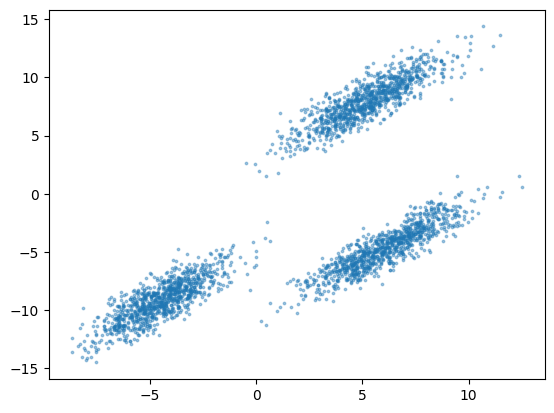

In [32]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

#### Model

##### Định nghĩa class dùng build GMM model

In [41]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

##### Xây dựng GMM model

In [42]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

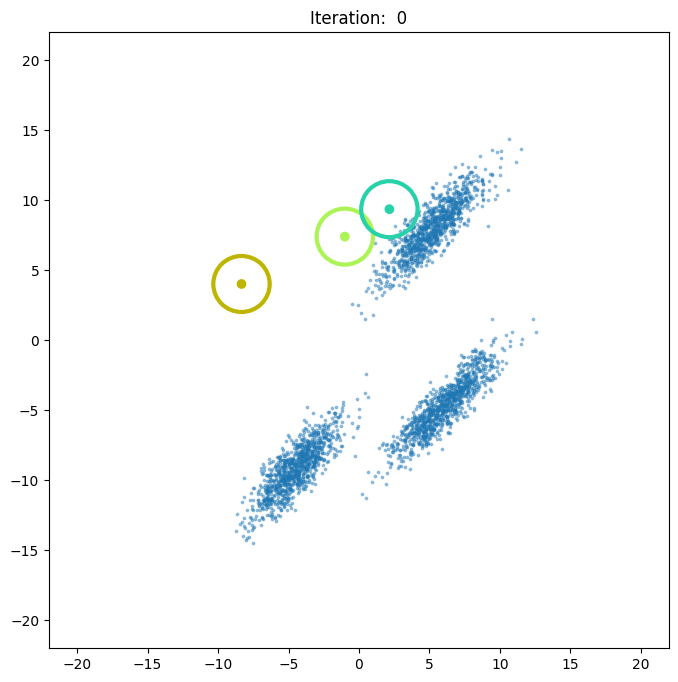

Iteration: 1, log-likelihood: -15702.0323


<Figure size 640x480 with 0 Axes>

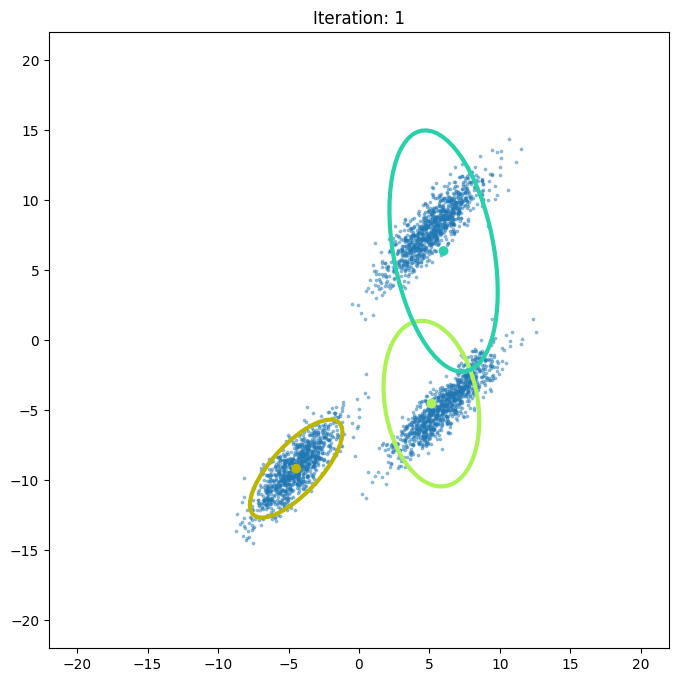

Iteration: 2, log-likelihood: -14872.1328


<Figure size 640x480 with 0 Axes>

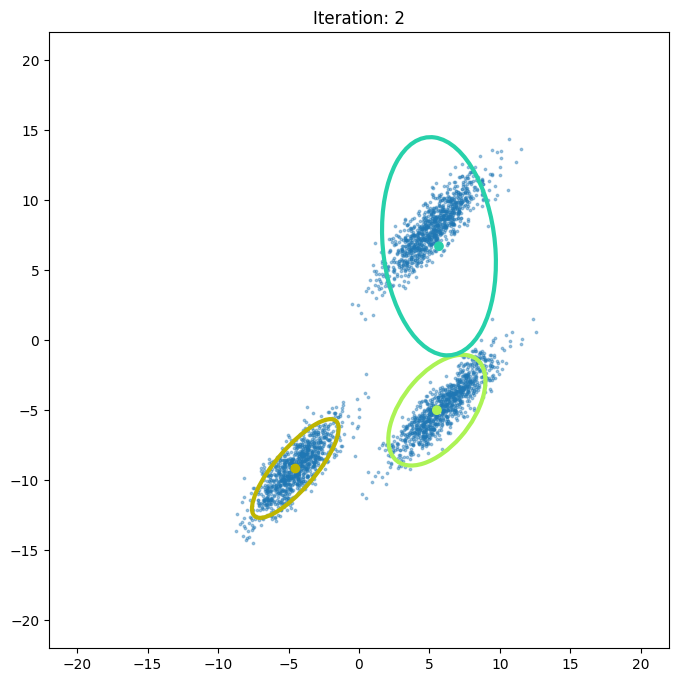

Iteration: 3, log-likelihood: -13973.2406


<Figure size 640x480 with 0 Axes>

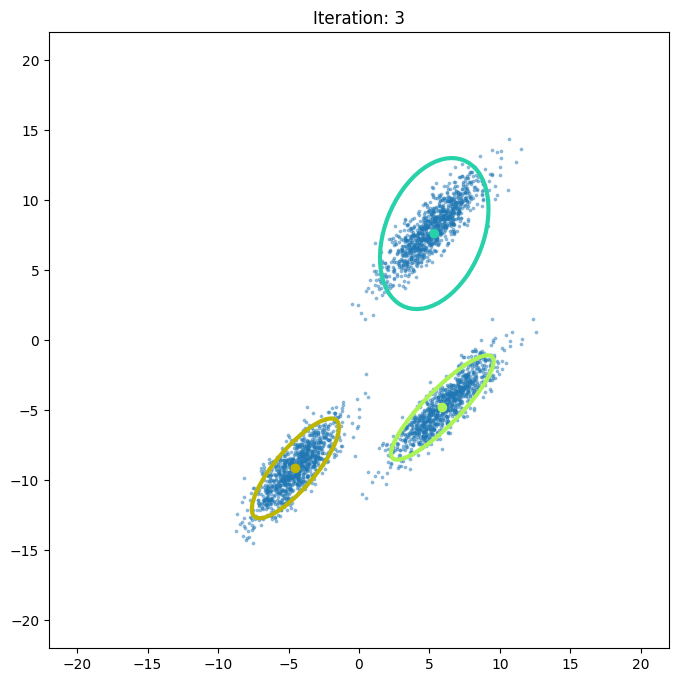

Iteration: 4, log-likelihood: -13373.0102


<Figure size 640x480 with 0 Axes>

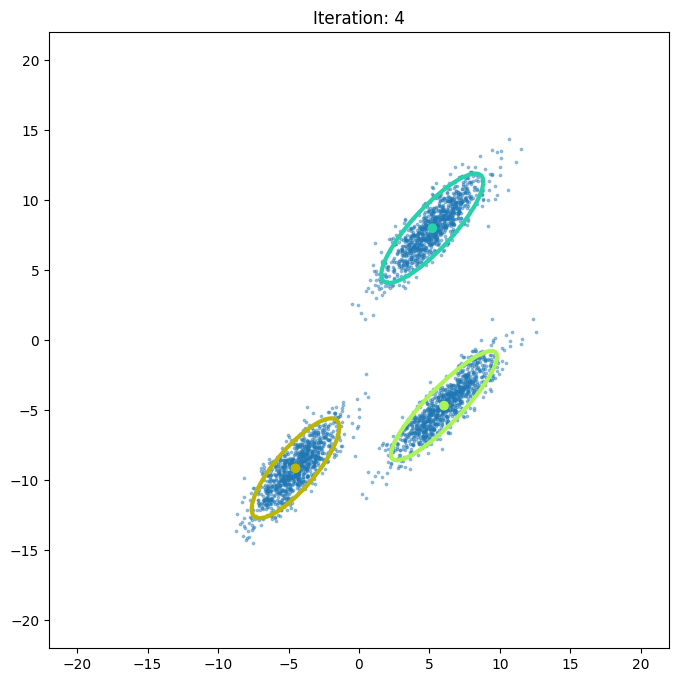

Iteration: 5, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

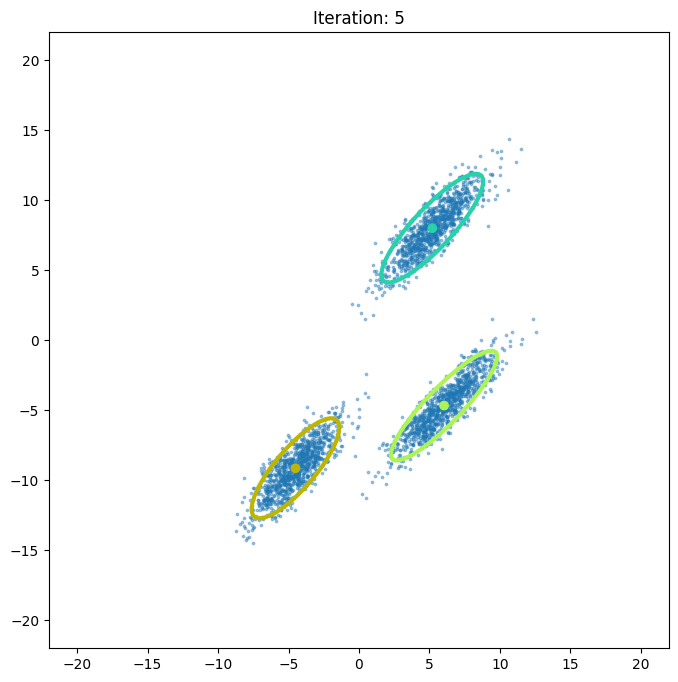

Iteration: 6, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

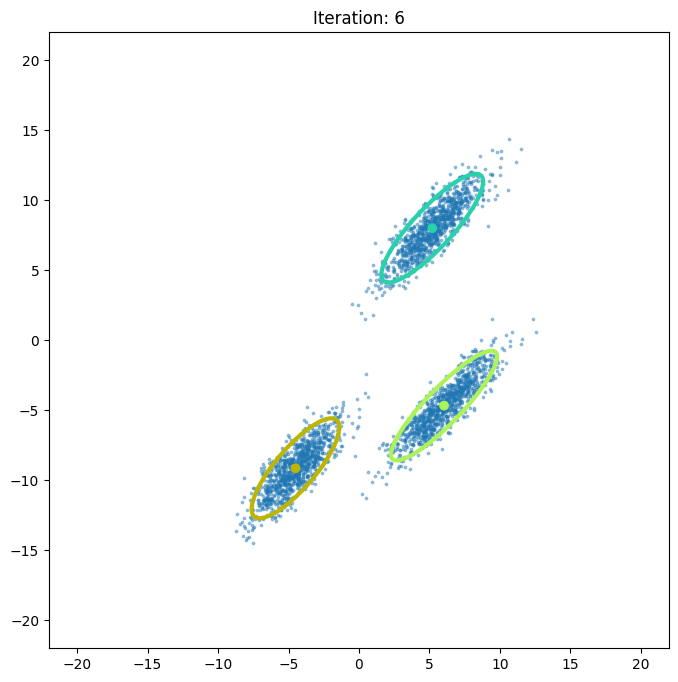

Iteration: 7, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

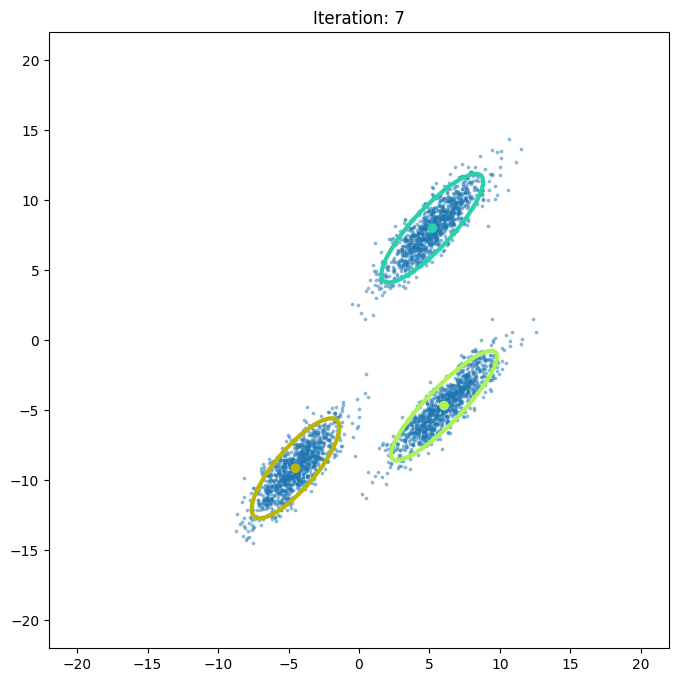

Iteration: 8, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

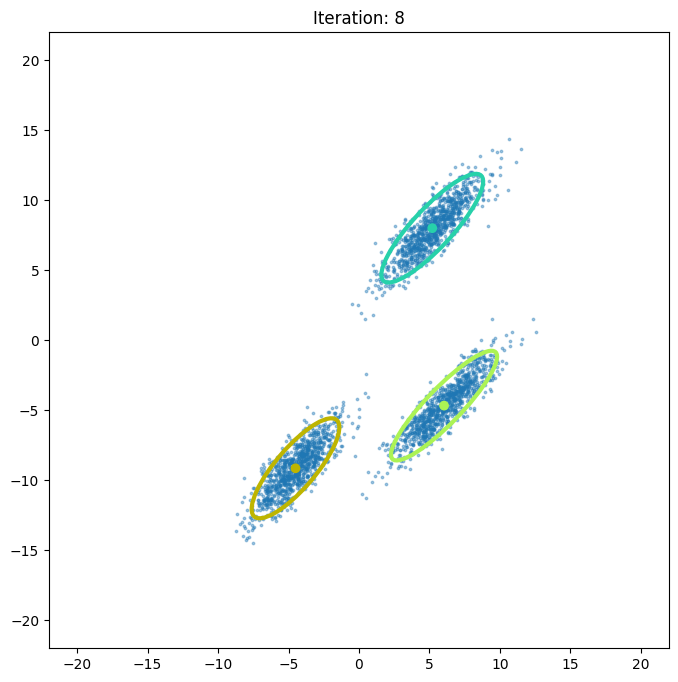

Iteration: 9, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

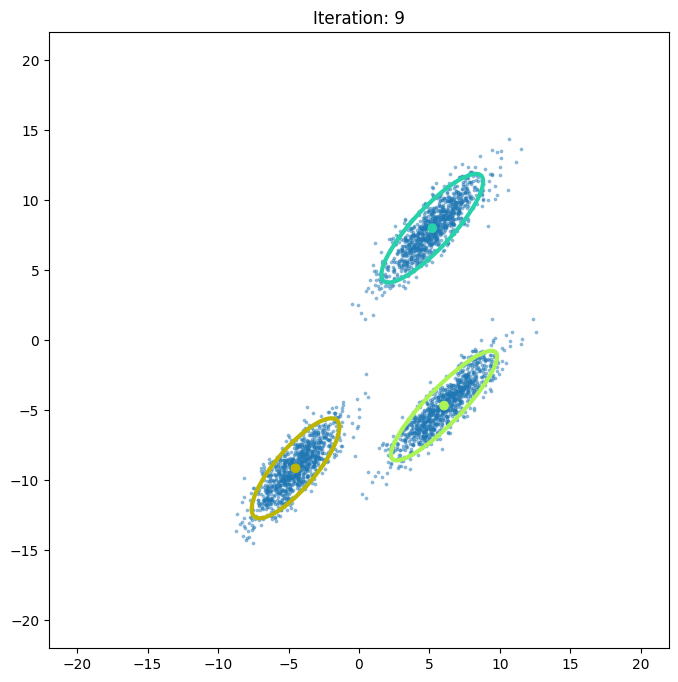

Iteration: 10, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

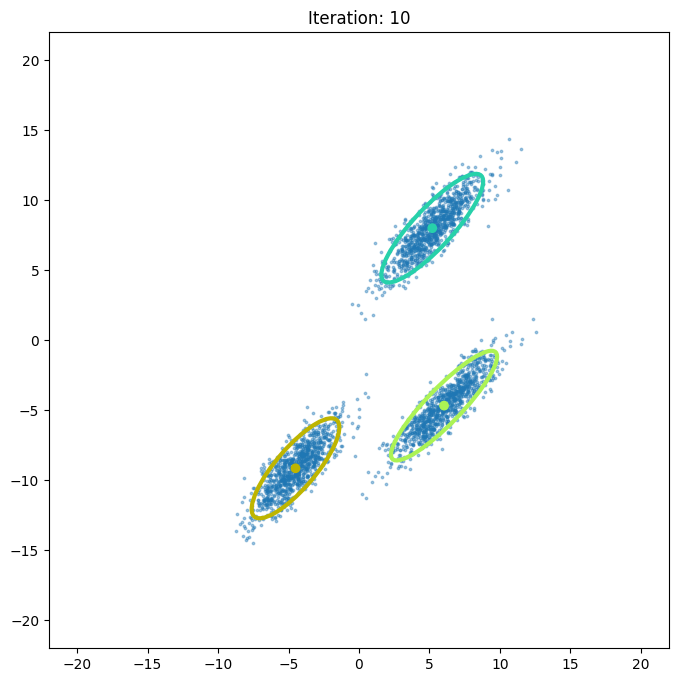

Iteration: 11, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

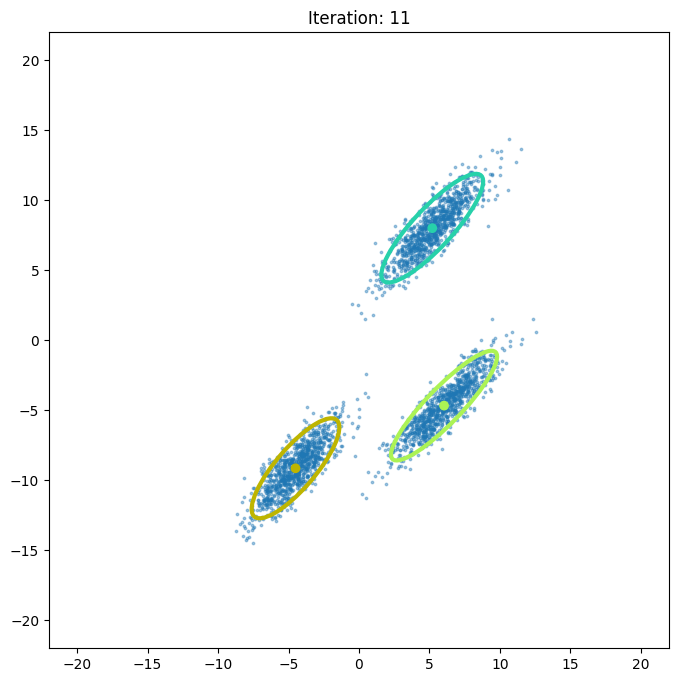

Iteration: 12, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

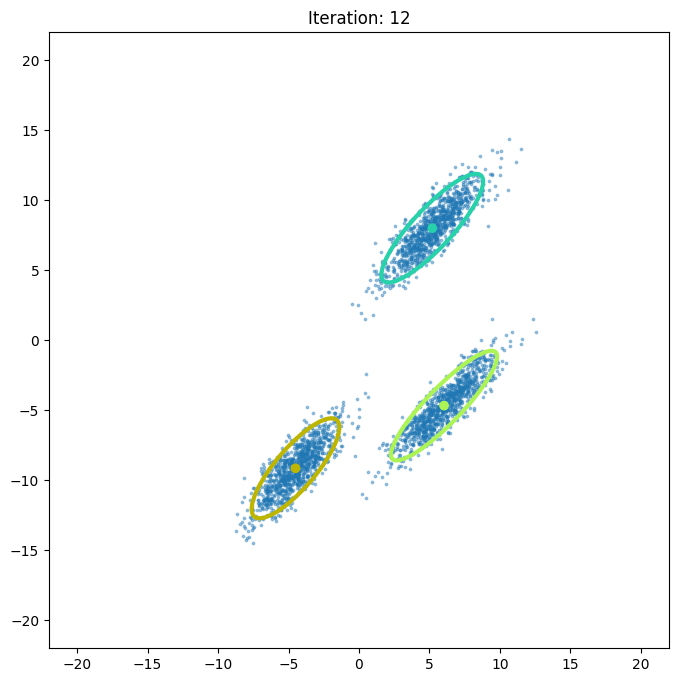

Iteration: 13, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

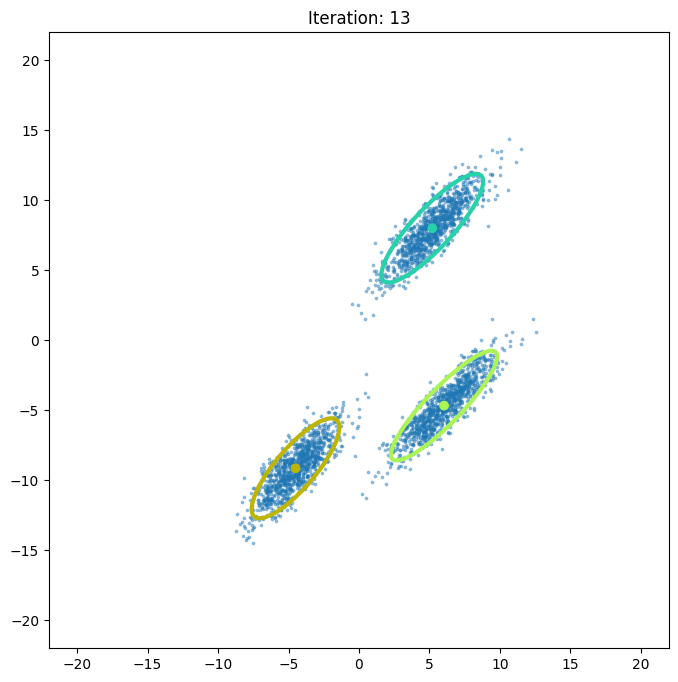

Iteration: 14, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

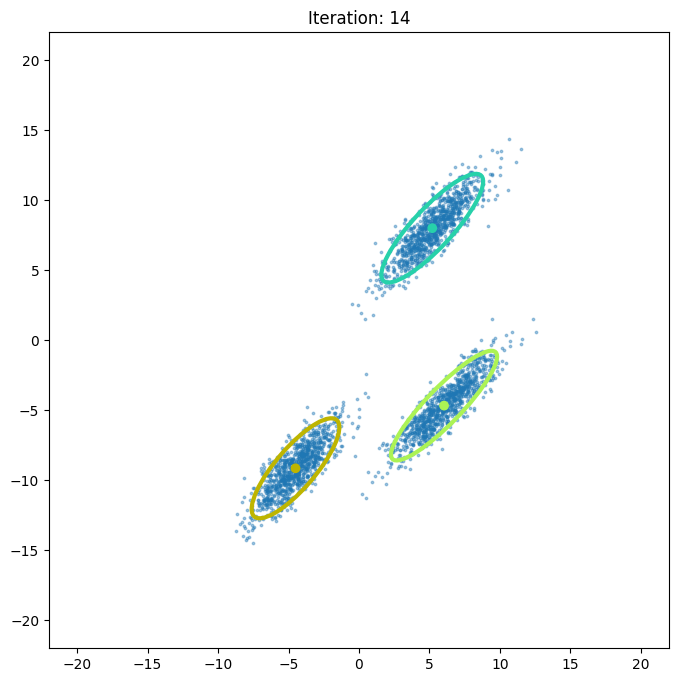

Iteration: 15, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

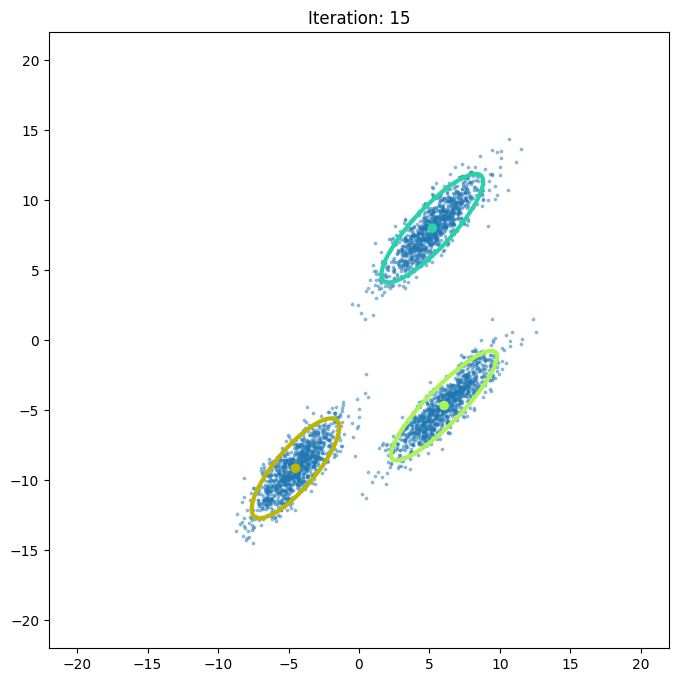

Iteration: 16, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

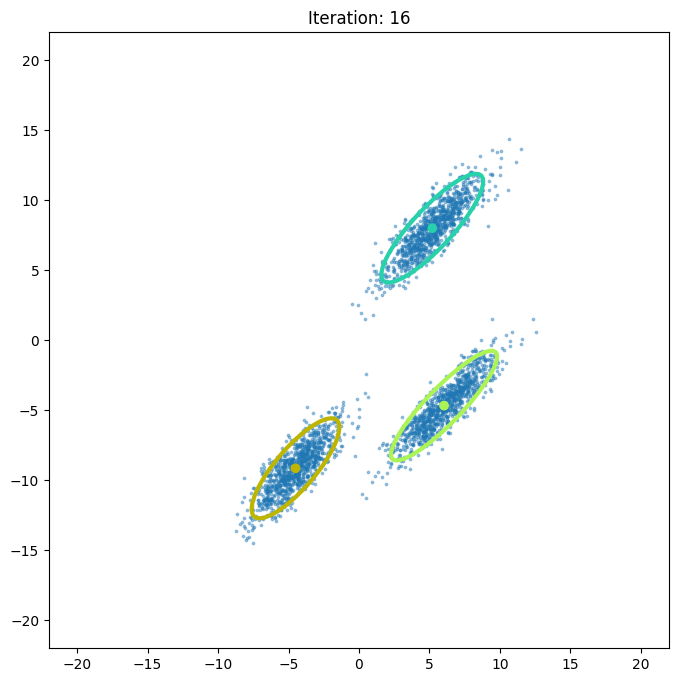

Iteration: 17, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

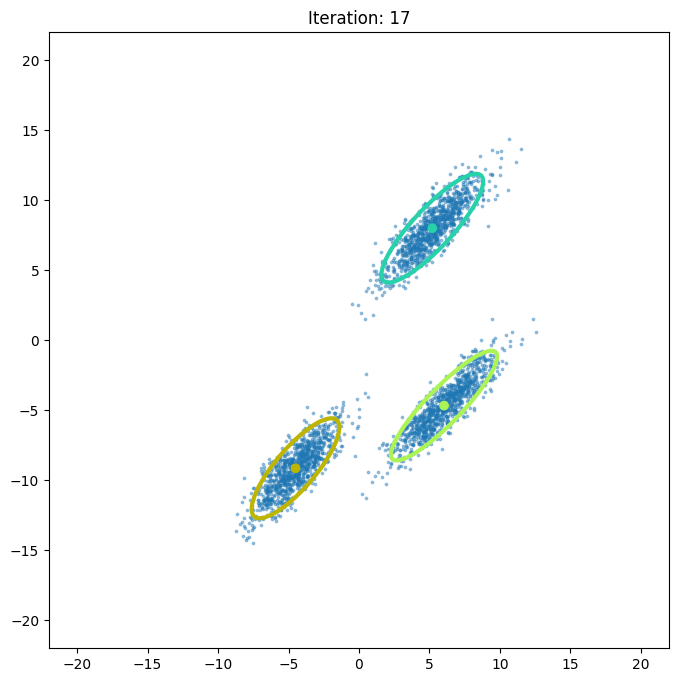

Iteration: 18, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

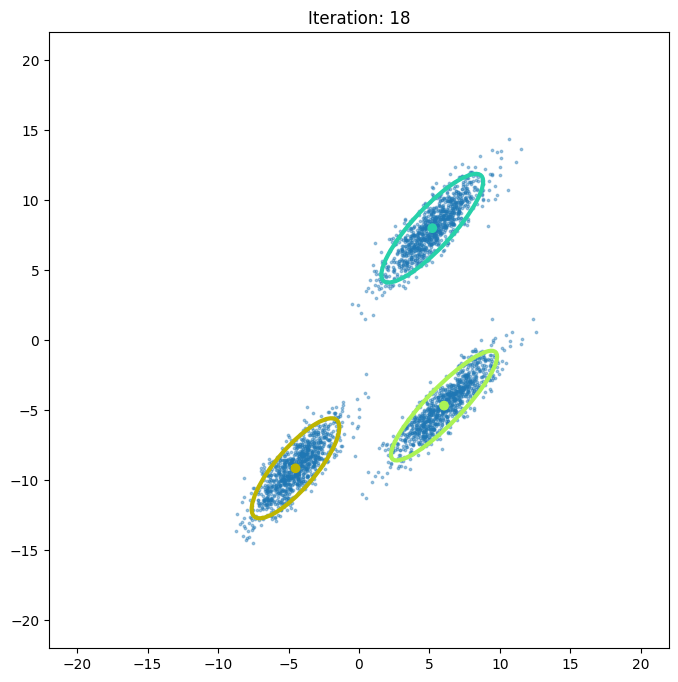

Iteration: 19, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

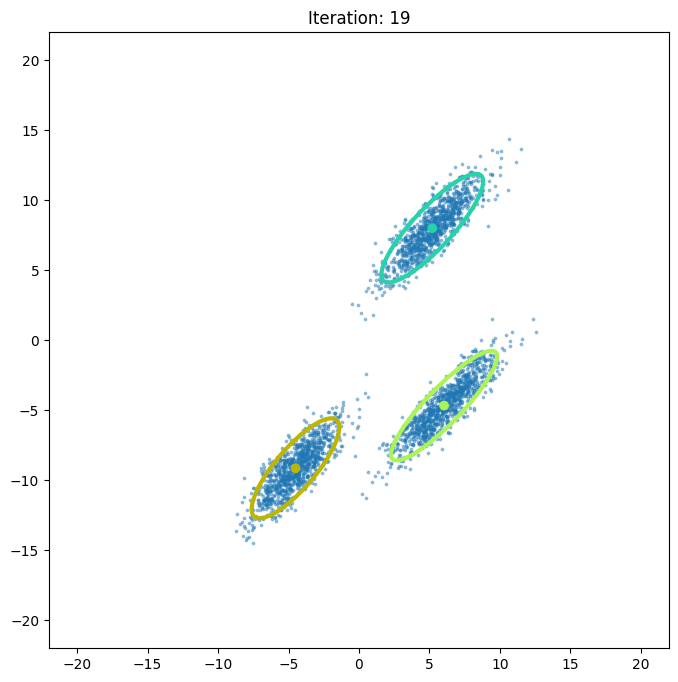

Iteration: 20, log-likelihood: -13371.6950


<Figure size 640x480 with 0 Axes>

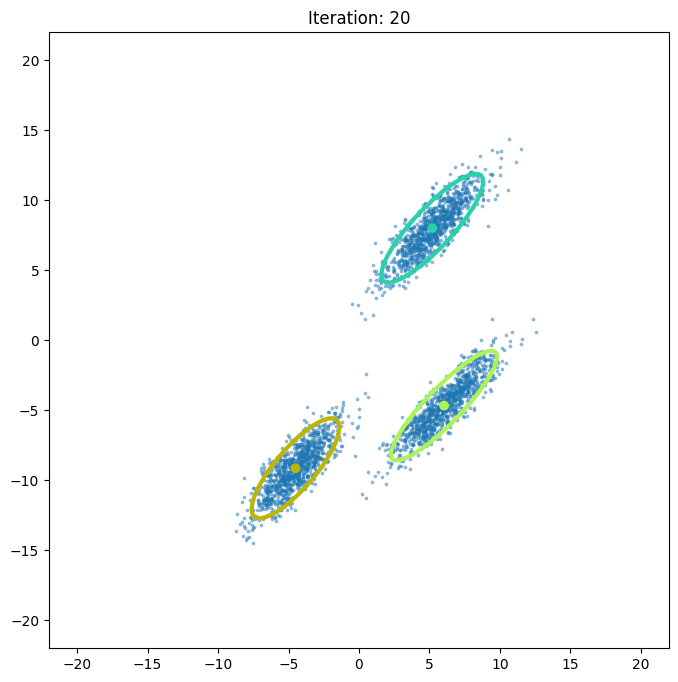

<Figure size 640x480 with 0 Axes>

In [43]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

### Bài tập tự thực hành 

#### Bài 1  
Sử dụng đoạn code trên để áp dựng cho dữ liệu là phần đầu vào của tập dữ liệu hoa Iris (bỏ trường tên loại hoa). Sau khi phân cụm xong hãy đối sánh kết quả với các phân loại đúng.

In [48]:
from sklearn.datasets import load_iris

# Load labels for comparison
iris = load_iris()
X = iris.data
iris_labels = iris.target

In [51]:
from sklearn.decomposition import PCA
# Reduce the dimensionality of X to 2 dimensions using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

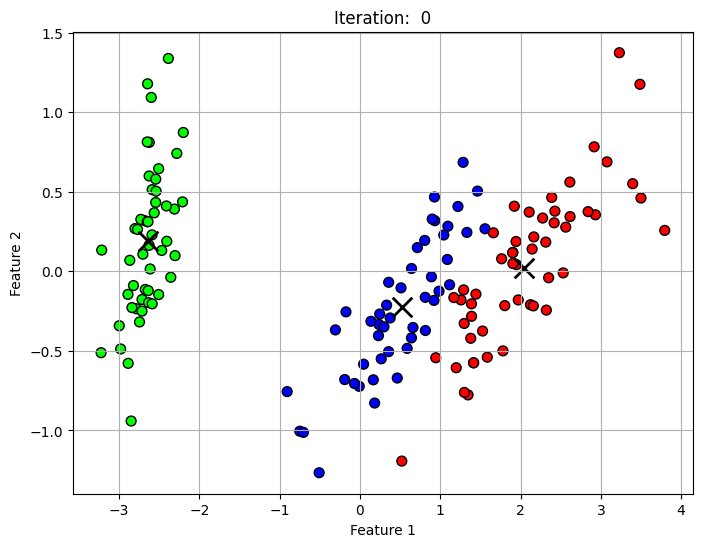

Iteration: 1, log-likelihood: -1.8747


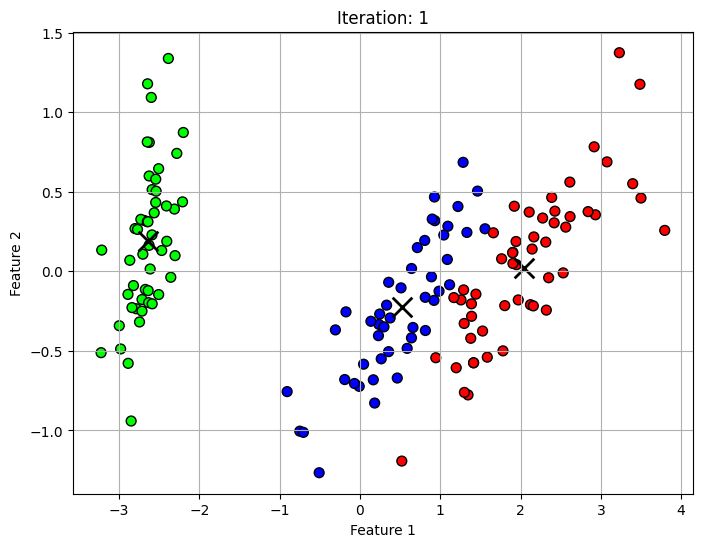

Iteration: 2, log-likelihood: -1.8747


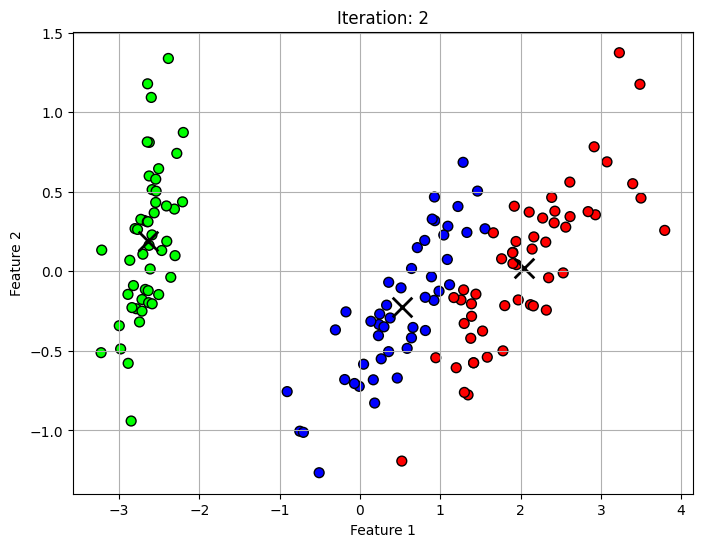

Iteration: 3, log-likelihood: -1.8747


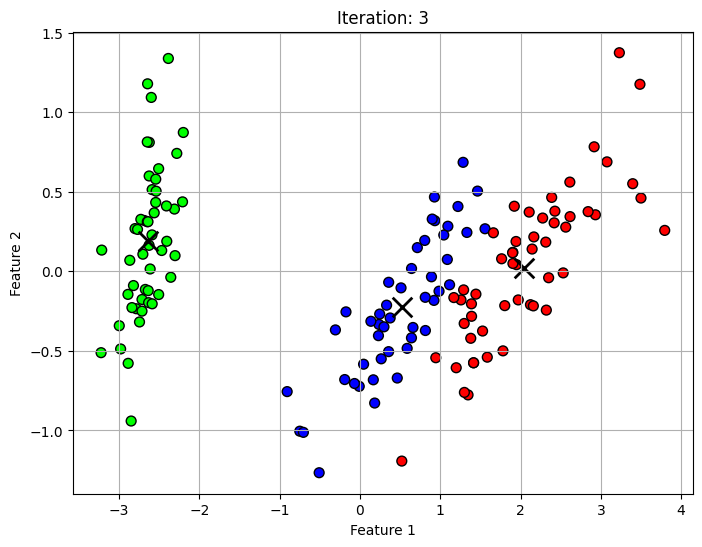

Adjusted Rand Index (GMM): 0.9410449800736683


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

# Define a colormap for the plot
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Function to plot data and GMM clusters
def plot_iteration(X, gmm, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), marker='o', s=50, cmap=cmap, edgecolor='k')
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', s=200, color='k', linewidths=2)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.show()

# Training the GMM using EM
gmm = GaussianMixture(n_components=3, random_state=42)

# Fit the model
gmm.fit(X_reduced)

num_iters = 3   # vì ngay sau lần lặp đầu tiên gần như không có sự thay đổi tiếp 
# Saving log-likelihood
log_likelihood = [gmm.score(X_reduced)]
# plotting
plot_iteration(X_reduced, gmm, title="Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.fit(X_reduced)
    # M-step
    # Computing log-likelihood
    log_likelihood.append(gmm.score(X_reduced))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot_iteration(X_reduced, gmm, title="Iteration: " + str(e+1))

# Convert cluster labels to match with true labels
predicted_labels_gmm = gmm.predict(X_reduced)
ari_gmm = adjusted_rand_score(iris_labels, predicted_labels_gmm)

print("Adjusted Rand Index (GMM):", ari_gmm)

#### Bài 2  
Hãy sử dụng thuật toán K-means để phân cụm dữ liệu tự tạo đã có trong ví dụ 1 của phần này. So sánh và giải thích kết quả.

## Sử dụng thư viện sk-learn

### Ví dụ triển khai lý thuyết

### Ví dụ mở rộng